In [1]:
import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import torch.optim as optim


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.pool =  nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32,16,3)
        
        self.fc1 = nn.Linear(16*10*10,256)
        self.fc2 = nn.Linear(256,10)

    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        #32*24*24      32*12*12
        x = F.relu(self.conv2(x))
        #16*10*10 
        x = x.view(-1,16*10*10)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        
        return x

In [3]:
class MY_MNIST(Dataset):
    training_file = 'training.pt'
    test_file = 'test.pt'
    def __init__(self, root, transform=None,target_transform=None):
        self.target_transform = target_transform
        self.transform = transform
        self.data, self.targets = torch.load(root)
    
    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy(), mode='L')
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target
    def __len__(self) :
        return len(self.data)

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_loader = MY_MNIST(root='./mnist/MNIST/processed/training.pt', transform=transform )
test_loader = MY_MNIST(root='./mnist/MNIST/processed/test.pt', transform= transform)


In [5]:
train_dataloader = DataLoader(dataset=train_loader,
                                 batch_size=40,
                                 shuffle=True,
                                 num_workers=4)
test_dataloader = DataLoader(dataset=test_loader,
                                 batch_size=40,
                                 shuffle=True,
                                 num_workers=4)

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
#训练

def train_net(net, device, train_dataloader,optimizer, epoch):
    net.train()
    
    for i,(img,target) in enumerate(train_dataloader,0):
        img,target = img.to(device),target.to(device)
        optimizer.zero_grad()
        outputs = net(img)
        loss =  criterion(outputs,target)
        loss.backward()     
        optimizer.step()
        if i % 3000 == 0:
            print("Train Epoch : {} \t Loss : {:.6f}".format(epoch, loss.item()))


In [8]:
def test_net(net,device,test_dataloader):
    net.eval()
    correct = 0.0
    global Accuracy
    
    test_loss = 0.0
    
    with torch.no_grad():
        for img,target in test_dataloader:
            
            img,target = img.to(device), target.to(device)
            outputs = net(img)
            
            test_loss += F.cross_entropy(outputs,target).item()
            # 找到概率值最大的下标
            pred = outputs.max(1, keepdim=True)[1]
            #pred = torch.max(output, dim=1)
            # pred = output.argmax(dim=1)
            # 累计正确的值
            correct += pred.eq(target.view_as(pred)).sum().item()
            Accuracy = correct/len(test_dataloader.dataset)*100.0
        test_loss /= len(test_dataloader.dataset)
        print("Test -- Average Loss : {:.4f}, Accuracy : {:.3f}\n".format(test_loss,Accuracy ))
        

In [9]:
accuracy_values = []
for epoch in range(1, 6):
    train_net(net,DEVICE,train_dataloader, optimizer,epoch)
    test_net(net,DEVICE,test_dataloader)  
    
    accuracy_values.append(Accuracy)
    

Train Epoch : 1 	 Loss : 2.296911
Test -- Average Loss : 0.0052, Accuracy : 93.980

Train Epoch : 2 	 Loss : 0.199567
Test -- Average Loss : 0.0027, Accuracy : 96.820

Train Epoch : 3 	 Loss : 0.039616
Test -- Average Loss : 0.0018, Accuracy : 97.820

Train Epoch : 4 	 Loss : 0.025680
Test -- Average Loss : 0.0015, Accuracy : 98.180

Train Epoch : 5 	 Loss : 0.018837
Test -- Average Loss : 0.0013, Accuracy : 98.330



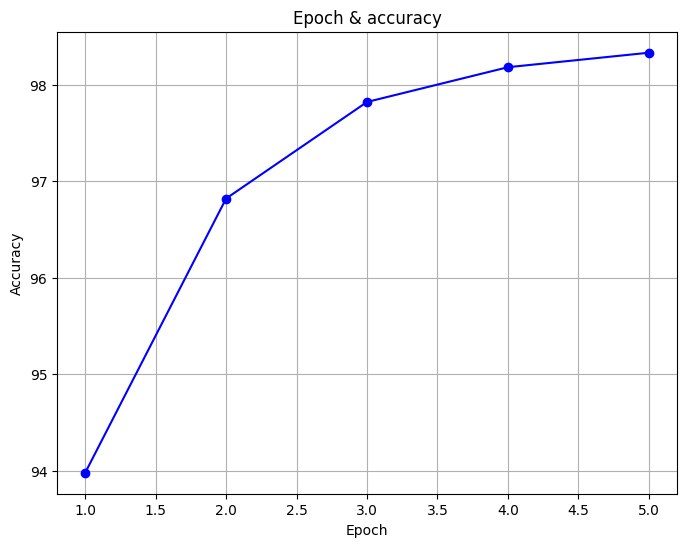

In [10]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Epoch & accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()